<a href="https://colab.research.google.com/github/Rajan-sust/MultiArmedBandit/blob/main/Thompson_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Source: https://github.com/WhatIThinkAbout/BabyRobot

In [1]:
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.core.pylabtools import figsize

In [3]:
def random_argmax(value_list):
  """ a random tie-breaking argmax"""
  values = np.asarray(value_list)
  return np.argmax(np.random.random(values.shape) * (values == values.max()))

In [4]:
random_argmax([0.1, 0.2, 0.3])

2

In [5]:
class PowerSocket:
    """ the base power socket class """
    
    def __init__(self, q):                
        self.q = q        # the true reward value              
        self.initialize() # reset the socket
        
    def initialize(self):
        self.Q = 0   # the estimate of this socket's reward value                
        self.n = 0   # the number of times this socket has been tried        
    
    def charge(self):
        """ return a random amount of charge """
        
        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        value = np.random.randn() + self.q        
        
        # never allow a charge less than 0 to be returned        
        return 0 if value < 0 else value
                    
    def update(self,R):
        """ update this socket after it has returned reward value 'R' """     
    
        # increment the number of times this socket has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R
    
    def sample(self,t):
        """ Return an estimate of the socket's reward value """
        return self.Q

class BernoulliThompsonSocket( PowerSocket ):
    def __init__( self, q ):             
                
        self.α = 1  # the number of times this socket returned a charge        
        self.β = 1  # the number of times no charge was returned
        
        # pass the true reward value to the base PowerSocket             
        super().__init__(q)          
    
    def charge(self):        
        """ return some charge with the socket's predefined probability """
        return np.random.random() < self.q
                    
    def update(self,R):
        """ increase the number of times this socket has been used and 
            update the counts of the number of times the socket has and 
            has not returned a charge (alpha and beta)"""
        self.n += 1    
        self.α += R
        self.β += (1-R)
        
    def sample(self):
        """ return a value sampled from the beta distribution """
        return np.random.beta(self.α, self.β)

In [6]:

figsize(11.0, 10)
beta = stats.beta
x = np.linspace(0.0,1.0,200)

def plot_sockets(sockets, socket_probabilities ):
    
    trials = sum([socket.n for socket in sockets])
    
    colors = ["green","red","blue"]
    c_index = 0    
    
    for i in range(len(socket_probabilities)):
        
        c = colors[c_index]
        y = beta( sockets[i].α, sockets[i].β )
        p = plt.plot(x, y.pdf(x), lw=2, color=c, label = f'{sockets[i].α-1}/{sockets[i].n}')
        plt.fill_between(x, y.pdf(x), 0, color=c, alpha=0.2 )
        plt.vlines(socket_probabilities[i], 0, y.pdf(socket_probabilities[i]), colors = c, linestyles = "--", lw = 2)
        plt.autoscale(tight = "True")
        plt.title(f"{trials} Trials")
        plt.legend()
        plt.autoscale(tight=True)
        c_index += 1

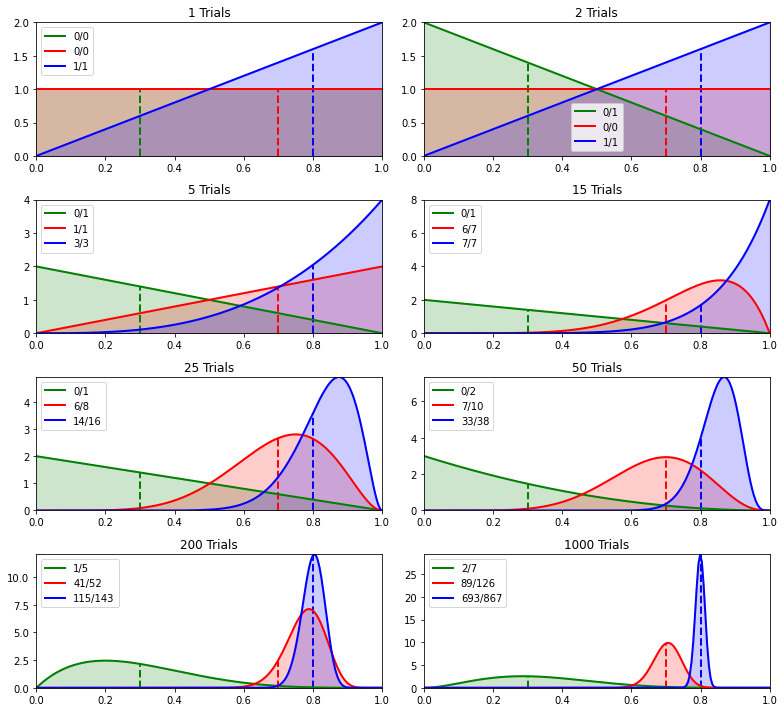

In [11]:
# set the random seed to produce a recreatable graph
seed = 15
random.seed(seed) 
np.random.seed(seed)

# the probabilities that each socket returns a charge
socket_probabilities = [0.3, 0.7, 0.8]

sockets = [BernoulliThompsonSocket(p) for p in socket_probabilities]

draw_samples = [1, 1, 3, 10, 10, 25, 150, 800]
# 1, 2, 5, ..., taking cumulative trial
for j,i in enumerate(draw_samples):
    plt.subplot(4, 2, j+1)         
    # print(i)
    for k in range(i):
        # choose the socket with the current highest sampled value or arbitrary select a socket in the case of a tie            
        socket_index = random_argmax([socket.sample() for socket in sockets])     

        # charge from the chosen socket and update its mean reward value
        reward = sockets[socket_index].charge()
        
        sockets[socket_index].update(reward)            
    # print(sockets[0].n)
    plot_sockets(sockets, socket_probabilities)
    
    plt.autoscale(tight = True)
plt.tight_layout()